false alarm rate is : 45.01 % , reduce to 24.62 %


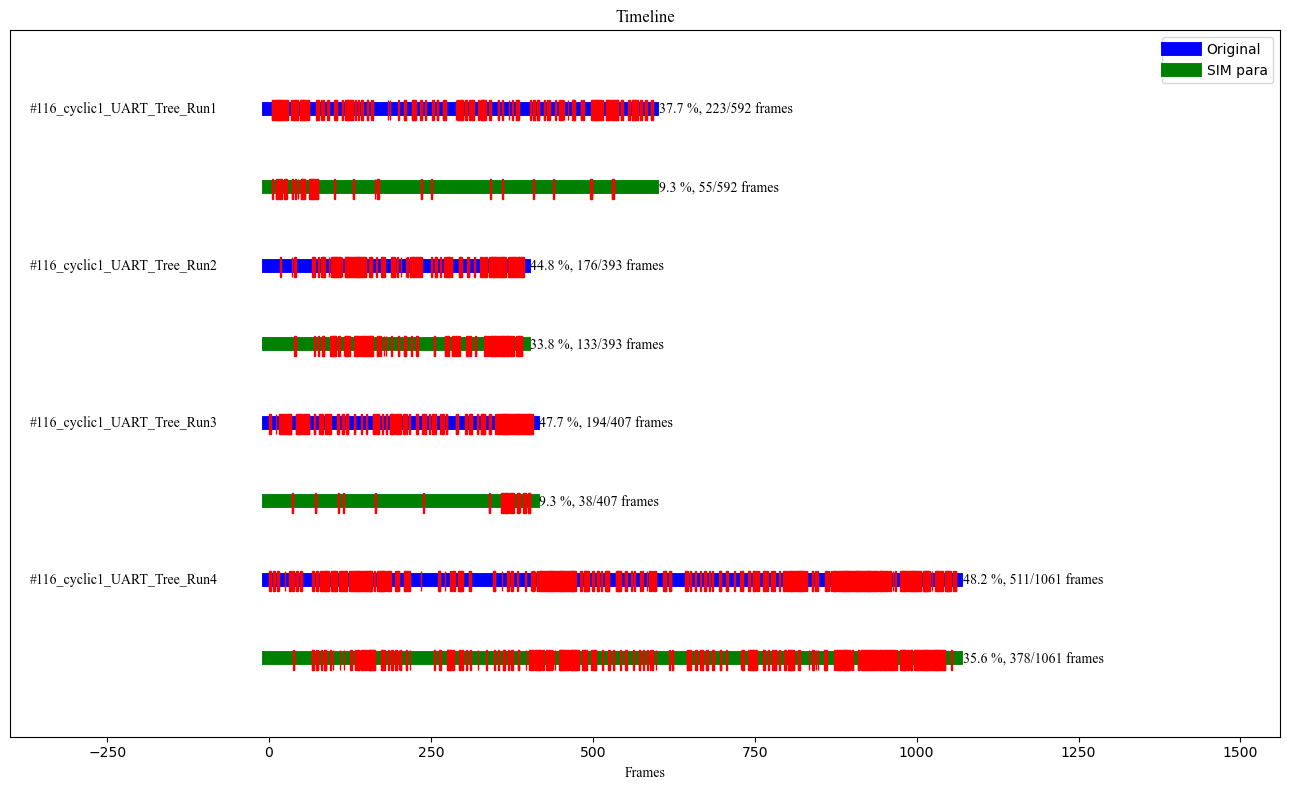

In [11]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def test(path, original, item):
    xlsx_files = glob.glob(f'{path}')

    data_list = []
    fig, ax = plt.subplots(figsize=(13, len(xlsx_files) * 2))  # Adjusted figure size for better spacing
    max_frame_tmp = 0
    SIM_ff = 0
    total_frame = 0
    orig_ff = 0

    for index, xlsx_file in enumerate(xlsx_files):
        xlsx_SIM = xlsx_file.replace(original, item)
        index_c = 2 * index

        # Read the data from Excel files
        data = pd.read_excel(xlsx_file, sheet_name='TrackedTarget', engine="openpyxl")
        data_SIM = pd.read_excel(xlsx_SIM, sheet_name='TrackedTarget', engine="openpyxl")
        data.rename(columns={'@_Frame': 'FrameNo'}, inplace=True)
        data_SIM.rename(columns={'@_Frame': 'FrameNo'}, inplace=True)
        data_pc = pd.read_excel(xlsx_file, sheet_name='CloudPoint', engine="openpyxl")

        file_name = os.path.basename(xlsx_file).split(".")[0]
        end_frame = data_pc['@_Frame'].max()
        start_from = data_pc['@_Frame'].min()
        each_frame = end_frame - start_from + 1

        fa_location = pd.DataFrame(columns=['FrameNo', 'Result', 'orig_result'])

        # Gather the results for each frame
        for frame in range(start_from, end_frame + 1):
            result = 1 if (data_SIM[data_SIM['FrameNo'] == frame]['@_Stat'] == 3).any() else 0
            orig_result = 1 if (data[data['FrameNo'] == frame]['@_Stat'] == 3).any() else 0
            fa_location = fa_location._append({'FrameNo': frame, 'Result': result, 'orig_result': orig_result}, ignore_index=True)    

        # Update maximum frame count
        if max_frame_tmp < each_frame:
            max_frame_tmp = each_frame

        avg = sum(fa_location['Result']) / each_frame * 100
        ff_point = sum(fa_location['Result'])
        orig_avg = sum(fa_location['orig_result']) / each_frame * 100
        orig_ff_point = sum(fa_location['orig_result'])

        # Plot original results using rectangles for better proportionality
        ax.plot([0, each_frame], [-index_c, -index_c], color='blue', linewidth=10, label='Original' if index == 0 else "", zorder = 1)
        for ind, ff in enumerate(fa_location['orig_result']):
            if ff == 1:
                rect = Rectangle((ind, -index_c - 0.14), 1.2, 0.25, color='red', zorder = 2)
                ax.add_patch(rect)

        # Plot decision tree results using rectangles
        ax.plot([0, each_frame], [-index_c-1, -index_c-1], color='green', linewidth=10, label='SIM para' if index == 0 else "", zorder = 1)
        for ind, ff in enumerate(fa_location['Result']):
            if ff == 1:
                rect = Rectangle((ind, -index_c - 1.15), 1.2, 0.25, color='red', zorder = 2)
                ax.add_patch(rect)

        # Add file name and statistics
        ax.text(-370, -index_c, file_name, verticalalignment='center', font='Times New Roman')
        ax.text(each_frame + 10, -index_c, f'{orig_avg:.1f} %, {orig_ff_point}/{each_frame} frames', verticalalignment='center', font='Times New Roman')
        ax.text(each_frame + 10, -index_c-1, f'{avg:.1f} %, {ff_point}/{each_frame} frames', verticalalignment='center', font='Times New Roman')

        total_frame += each_frame
        orig_ff += orig_ff_point
        SIM_ff += ff_point

    print(f"false alarm rate is : {orig_ff / total_frame * 100:.2f} % , reduce to {SIM_ff / total_frame * 100:.2f} %")

    ax.set_xlim(-400, max_frame_tmp + 500)
    ax.set_ylim(-len(xlsx_files) * 2, 1)
    ax.set_yticks([])
    ax.set_title("Timeline", fontname='Times New Roman')
    ax.set_xlabel("Frames", fontname='Times New Roman')
    ax.legend()
    ax.set_aspect(aspect='auto')
    plt.tight_layout()  # Adjust layout for better fit
    # plt.savefig('original_aac3.svg', format='svg')
    plt.show()

path = 'D:/OneDrive/umec/project/20230901-Tmp_Assignment/20250102-treefilter/ff/s0/*'
test(path, "s0", "s5")